In [1]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import randrange, uniform
from scipy.stats import norm
import math
import copy

# My algorithm

In [10]:
def EI(mean,var,y_max):

  z = (mean - y_max)/np.sqrt(var)        
  out=(mean - y_max) * norm.cdf(z) + np.sqrt(var) * norm.pdf(z)

  return out 


def findmax(mean,var,fstar):
   z = (fstar - mean)/np.sqrt(var)  
   out = norm.pdf(z)   

   return out
 
 
def MES(mean,var,fstar):
    
  gamma = (fstar-mean)/np.sqrt(var)  
  
  out = (gamma*norm.pdf(gamma))/(2*norm.cdf(gamma))-np.log(norm.cdf(gamma))

  return out 


def over_max(mean,var,fstar):
  z = (fstar - mean)/np.sqrt(var)   
  below_max = norm.cdf(z)
  out = 1 - below_max
  
  return out 
 
 
def init(X_total, Y_total, seed):

  np.random.seed(seed)
  
  X_sample = []
  Y_sample = []


  for i in range(3):
    x_index = int(np.random.randint(X_total.shape[0], size=1))


    X_temp = X_total[x_index]
    Y_temp = Y_total[x_index]

    X_sample.append(X_temp)
    Y_sample.append(Y_temp)

  return np.array(X_sample),np.array(Y_sample).reshape(-1,)


def trans (Y_sample,fstar):
  value = np.sqrt(2*(fstar-Y_sample))

  return value

In [44]:
def normal_BO(X_total,Y_total,acquisition,fstar,seed): 
  
  AF_holder = []  ##############
  
  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total,seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.kern.variance.fix()
    m.Gaussian_noise.variance.fix(0.0)
    #m.optimize() 

    # m_var = m.rbf.variance
    # m_lengthscale = m.rbf.lengthscale
    

    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)

    if acquisition == 'ei':
      acq_value = EI(mean,var,Y_max_holder[-1])
    elif acquisition == 'findmax':
      acq_value = findmax(mean,var,fstar)
    elif acquisition == 'tei':
      part1 = EI(mean,var,Y_max_holder[-1])
      part2 = EI(mean,var,fstar)
      acq_value = part1-part2
    elif acquisition == 'mes':
      acq_value = MES(mean,var,fstar)
    elif acquisition == 'over_max':
      acq_value = over_max(mean,var,fstar)

    #print(mean[mean>fstar])
    #print('this is variance: ', var)
    
    AF_holder.append(acq_value)  ################

    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder   #,m #, AF_holder

In [45]:
def PO_BO(X_total,Y_total, fstar, seed): 

  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total, seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)

    #m.optimize()
    #print(m)

    # m_var = m.rbf.variance
    # m_lengthscale = m.rbf.lengthscale


    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        kernel_temp = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,1),Y_sample_temp.reshape(-1,1),kernel_temp)
        m_temp.Gaussian_noise.variance.fix(0.0)

        # if i%20 == 0:
        #   m_temp.plot()
        #   plt.xlim(0,10)

        mean_temp,var_temp = m_temp.predict(X_total.reshape(-1,1),include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.min(PnI)
        part2_total[i] = part2

    acq_value = part1_total*part2_total




    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [46]:
def PO_BO2(X_total,Y_total, fstar, seed): 

  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total, seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)


    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X.shape[0])

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        kernel_temp = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,1),Y_sample_temp.reshape(-1,1),kernel_temp)
        m_temp.Gaussian_noise.variance.fix(0.0)

        # if i%20 == 0:
        #   m_temp.plot()
        #   plt.xlim(0,10)

        mean_temp,var_temp = m_temp.predict(X_total.reshape(-1,1),include_likelihood=False)
        z = (fstar-mean_temp)/np.sqrt(var_temp)
        PnI = norm.cdf(z)
        part2 = np.prod(PnI**(1/15))
        part2_total[i] = part2
        
    #print('part2: ',part2_total)

    acq_value = part1_total*part2_total




    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [5]:
def PO_BO_MC(X_total,Y_total, fstar, seed): 

  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total, seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)


    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    part1_total = findmax(mean,var,fstar)
    part1_total = part1_total.reshape(-1,)

    part2_total = np.zeros(X.shape[0])
    

    for i in range(X_total.shape[0]):
        X_sample_temp = np.concatenate((X_sample, np.array([X_total[i]])), axis=0)
        Y_sample_temp = np.concatenate((Y_sample, np.array([fstar])), axis=0)

        kernel_temp = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
        m_temp = GPy.models.GPRegression(X_sample_temp.reshape(-1,1),Y_sample_temp.reshape(-1,1),kernel_temp)
        m_temp.Gaussian_noise.variance.fix(0.0)
        
        mean_temp,var_temp = m_temp.predict(X_total.reshape(-1,1),full_cov=True)
        num_sample =25
        np.random.seed(seed) #here I fix random seed so that 
        posteriorY = np.random.multivariate_normal(mean_temp.reshape(-1,), var_temp, size=num_sample)
        
        count = 0
        for j in range(num_sample):
          temp = any(posteriorY[j]>fstar)+0.
          count = count+temp

        
        PI = count/num_sample
        PnI = 1-PI
        part2_total[i] = PnI

    acq_value = part1_total*part2_total




    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)


  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [6]:
def KG_BO(X_total,Y_total, fstar, seed): 

  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total, seed)
  
  Y_record = Y_sample

  #print(X_sample)
  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)
    
    #use max_mean to end KG
    # mean,_ = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    # index = np.argmax(mean)
    # #X_final = X_total[index]
    # Y_final = Y_total[index]
    # Y_record = np.concatenate((Y_record, np.array([Y_final])), axis=0)  
       
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    p1 = EI(mean,var,Y_max_holder[-1])
    p2 = EI(mean,var,fstar)
    acq_value_last = p1-p2   # the last step is TEI
    index = np.argmax(acq_value_last)
    Y_final = Y_total[index]
    Y_record = np.concatenate((Y_record, np.array([Y_final])), axis=0) 
    
    Y_max= np.max(Y_record)
    Y_max_holder.append(Y_max)
    
    if n==total_round-1:
      break
    
    # KG  
    fansty_mean_holder = []
    
    for i in range(X_total.shape[0]): #calculate the expected mean 2 steps ahead
        sample_size = 15
        X_fansty = np.array([X_total[i] ])
        samples_fantsy = m.posterior_samples_f(X_fansty.reshape(-1,1),size=sample_size).reshape(-1)
        samples_fantsy[samples_fantsy > fstar] = fstar # truncate the fansty points
        
        fansty_mean_holder_temp = []
        
        for y_fansty in samples_fantsy:
            
            y_fansty = np.array([y_fansty])
            
            X_sample_fansty = np.concatenate((X_sample, X_fansty), axis=0)
            Y_sample_fansty = np.concatenate((Y_sample, y_fansty), axis=0)
            kernel_fansty = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
            m_fansty = GPy.models.GPRegression(X_sample_fansty.reshape(-1,1),Y_sample_fansty.reshape(-1,1),kernel_fansty)
            m_fansty.Gaussian_noise.variance.fix(0.0)
            mean_fansty,_ = m_fansty.predict(X_total.reshape(-1,1),include_likelihood=False)
            #mean_fansty[mean_fansty > fstar] = fstar 
            fansty_mean_holder_temp.append(np.max(mean_fansty))
            
        fansty_mean_holder_temp = np.array(fansty_mean_holder_temp)
        fansty_mean_holder.append(np.mean(fansty_mean_holder_temp))
        
    acq_value = fansty_mean_holder
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    
    # Y_max= np.max(Y_record)
    # Y_max_holder.append(Y_max)

  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

In [7]:
def entropy_xstar(X_total,mean,var,fstar):
    z = (fstar - mean)/np.sqrt(var)  
    pdf = norm.pdf(z)   
    
    delta = X_total[1]-X_total[0]
    normal_constant = 1/(delta*np.sum(pdf))
    
    P = pdf*normal_constant*delta
    logP = np.log(P)
    
    logP[logP == float('-inf')] = -800
    
    entropy = -np.sum(P*logP)
    
    return entropy
  
  
  
def ES_BO(X_total,Y_total, fstar, seed): 

  fstar_true = np.max(Y_total)
  print('optimum is ', fstar_true)

  total_round = 6
  Y_max_holder = []

  X_sample, Y_sample = init(X_total, Y_total, seed)

  #print(X_sample)

  Y_max= np.max(Y_sample)
  Y_max_holder.append(Y_max)

  m_var = 10 
  m_lengthscale = 1.2 

  for n in range(total_round):
    #train the GP model for X and centrailised Y
    
    kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
    m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
    m.Gaussian_noise.variance.fix(0.0)

    #m.optimize()
    #print(m)

    # m_var = m.rbf.variance
    # m_lengthscale = m.rbf.lengthscale


    #find the X that can maximize the acqusition function:
    mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
    part1_total = entropy_xstar(X_total,mean,var,fstar)

    part2_total = np.zeros(X.shape[0])

    for i in range(X_total.shape[0]):
        sample_size = 10
        X_fansty = np.array([X_total[i] ])
        samples_fantsy = m.posterior_samples_f(X_fansty.reshape(-1,1),size=sample_size).reshape(-1)
        
        fansty_entropy_holder_temp = []
        
        for y_fansty in samples_fantsy:
            
            y_fansty = np.array([y_fansty])
            
            X_sample_fansty = np.concatenate((X_sample, X_fansty), axis=0)
            Y_sample_fansty = np.concatenate((Y_sample, y_fansty), axis=0)
            kernel_fansty = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
            m_fansty = GPy.models.GPRegression(X_sample_fansty.reshape(-1,1),Y_sample_fansty.reshape(-1,1),kernel_fansty)
            m_fansty.Gaussian_noise.variance.fix(0.0)
            mean_fansty,var_fansty = m_fansty.predict(X_total.reshape(-1,1),include_likelihood=False)
            entropy_fansty = entropy_xstar(X_total,mean_fansty,var_fansty,fstar)
            fansty_entropy_holder_temp.append(entropy_fansty)
            
            
        fansty_entropy_holder_temp = np.array(fansty_entropy_holder_temp)
        part2_total[i] = np.mean(fansty_entropy_holder_temp)
        
    acq_value = part1_total-part2_total
    index = np.argmax(acq_value)
    X_chosen = X_total[index]
    Y_chosen = Y_total[index]

    X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
    Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

    Y_max= np.max(Y_sample)
    Y_max_holder.append(Y_max)

        

  Y_max_holder = np.array(Y_max_holder)
  regret_holder = fstar_true - Y_max_holder

  return regret_holder

# ERM


In [ ]:
# def paper_BO(X_total,Y_total,acquisition,seed): 

#   fstar = np.max(Y_total)
#   print('optimum is ', fstar)

#   total_round = 6
#   Y_max_holder = []

#   X_sample, Y_sample = init(X_total, Y_total, seed)

#   Y_max= np.max(Y_sample)
#   Y_max_holder.append(Y_max)

#   m_var = 10 
#   m_lengthscale = 1.2 

#   normal_BO = True

#   for n in range(total_round):

#     if normal_BO:
    
#       kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
#       m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_sample.reshape(-1,1),kernel)
#       m.kern.variance.fix()
#       m.Gaussian_noise.variance.fix(0.0)
#       m.optimize()

#       m_var = m.rbf.variance
#       m_lengthscale = m.rbf.lengthscale

      
#       # m.plot() ######
#       # plt.xlim(0,10)

#       #find the X that can maximize the acqusition function:
#       mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)

#       if acquisition == 'ei':
#         acq_value = EI(mean,var,Y_max_holder[-1])
#       elif acquisition == 'pi':
#         z = (Y_max_holder[-1]-mean)/np.sqrt(var)
#         PnI = norm.cdf(z)
#         acq_value = 1-PnI 
#       elif acquisition == 'new ei':
#         part1 = EI(mean,var,Y_max_holder[-1])
#         part2 = EI(mean,var,fstar)
#         acq_value = part1-part2

#       #calculate the ucb:
#       beta_t = np.log(Y_sample.shape [0])
#       output = mean + np.sqrt(beta_t) * np.sqrt(var)
#       normal_BO = all(output<fstar)

#       print(normal_BO)

#       index = np.argmax(acq_value)
#       X_chosen = X_total[index]
#       Y_chosen = Y_total[index]

#       X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
#       Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

#       Y_max= np.max(Y_sample)
#       Y_max_holder.append(Y_max)

#     else:
#       Y_transfromed = trans (Y_sample,fstar)

#       #train the model:
#       kernel = GPy.kern.RBF(input_dim=1,variance=m_var,lengthscale=m_lengthscale)
#       m = GPy.models.GPRegression(X_sample.reshape(-1,1),Y_transfromed.reshape(-1,1),kernel)
#       m.Gaussian_noise.variance.fix(0.0)
#       m.optimize()



#       mean,var = m.predict(X_total.reshape(-1,1),include_likelihood=False)
#       var2 = np.maximum(var, 1e-9 + 0 * var)
#       z = ( fstar-mean)/np.sqrt(var2)        
#       acq_value=(fstar-mean) * (norm.cdf(z)) + np.sqrt(var2) * norm.pdf(z)

#       index = np.argmax(acq_value)
#       X_chosen = X_total[index]
#       Y_chosen = Y_total[index]

#       X_sample = np.concatenate((X_sample, np.array([X_chosen])), axis=0)
#       Y_sample = np.concatenate((Y_sample, np.array([Y_chosen])), axis=0)

#       Y_max= np.max(Y_sample)
#       Y_max_holder.append(Y_max)


#   Y_max_holder = np.array(Y_max_holder)
#   regret_holder = fstar - Y_max_holder


#   return regret_holder

# two test functions

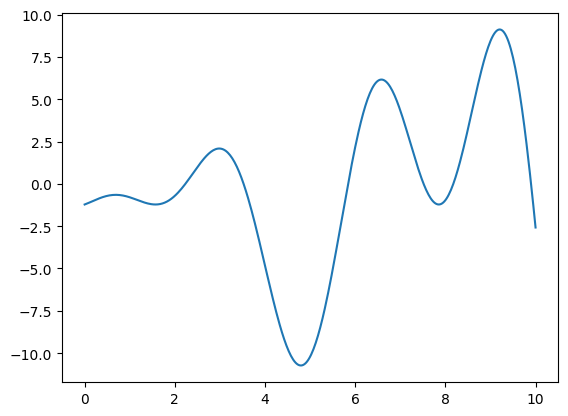

In [9]:
X = np.linspace(0,10,401)
Y = X*np.sin(X)+X*np.cos(2*X)-1.22

plt.plot(X,Y)

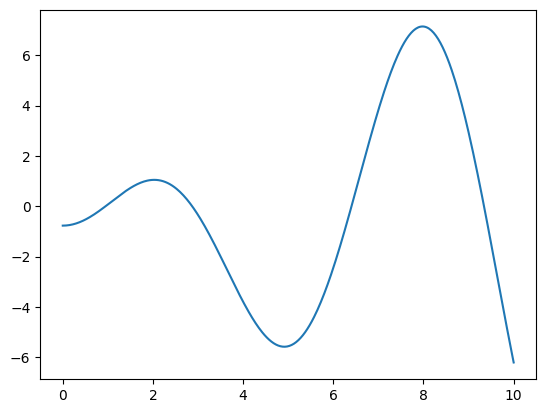

In [13]:
X = np.linspace(0,10,401)
Y = X*np.sin(X)-0.77
plt.plot(X,Y)

# run experiments


the exact f_star

In [52]:
N = 100
regret_holder11 = []
regret_holder22 = []
regret_holder33 = []
regret_holder44 = []
regret_holder55 = []


X = np.linspace(1,10,401)

for exp in range(N):
  print(exp+100)
  np.random.seed(exp+100) 
  
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret1 = normal_BO(X,Y,'ei',fstar=fstar,seed=exp+100)
  regret_holder11.append(regret1)


  regret2 = normal_BO(X,Y,'tei',fstar=fstar,seed=exp+100)
  regret_holder22.append(regret2)
  
  regret3 = normal_BO(X,Y,'mes',fstar=fstar,seed=exp+100)
  regret_holder33.append(regret3)  

  regret4 = PO_BO(X,Y, fstar=fstar, seed=exp+100)
  regret_holder44.append(regret4)
  
  regret5 = PO_BO2(X,Y, fstar=fstar, seed=exp+100)
  regret_holder55.append(regret5)

100
optimum is  4.687858280980242
optimum is  4.687858280980242
optimum is  4.687858280980242
optimum is  4.687858280980242
optimum is  4.687858280980242
101
optimum is  3.3315153356001836
optimum is  3.3315153356001836
optimum is  3.3315153356001836
optimum is  3.3315153356001836
optimum is  3.3315153356001836
102
optimum is  5.407860035491275
optimum is  5.407860035491275
optimum is  5.407860035491275
optimum is  5.407860035491275
optimum is  5.407860035491275
103
optimum is  4.139541661378705
optimum is  4.139541661378705
optimum is  4.139541661378705
optimum is  4.139541661378705
optimum is  4.139541661378705
104
optimum is  3.0673303473123417
optimum is  3.0673303473123417
optimum is  3.0673303473123417
optimum is  3.0673303473123417
optimum is  3.0673303473123417
105
optimum is  0.7069655169166732
optimum is  0.7069655169166732
optimum is  0.7069655169166732
optimum is  0.7069655169166732
optimum is  0.7069655169166732
106
optimum is  3.086093477290628
optimum is  3.0860934772906

In [47]:
N = 100
regret_holder1 = []
regret_holder2 = []
regret_holder3 = []
regret_holder4 = []
regret_holder5 = []


X = np.linspace(1,10,401)

for exp in range(N):
  print(exp)
  np.random.seed(exp) 
  
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret1 = normal_BO(X,Y,'ei',fstar=fstar,seed=exp)
  regret_holder1.append(regret1)


  regret2 = normal_BO(X,Y,'tei',fstar=fstar,seed=exp)
  regret_holder2.append(regret2)
  
  regret3 = normal_BO(X,Y,'mes',fstar=fstar,seed=exp)
  regret_holder3.append(regret3)  

  regret4 = PO_BO(X,Y, fstar=fstar, seed=exp)
  regret_holder4.append(regret4)
  
  regret5 = PO_BO2(X,Y, fstar=fstar, seed=exp)
  regret_holder5.append(regret5)

0
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
1
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
2
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
3
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
4
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
5
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
6
optimum is  5.315064539356177
optimum is  5.315064539356177
optimum is  5.315064539356

 /tmp/ipykernel_157840/3949994320.py:19: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3949994320.py:20: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3949994320.py:21: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3949994320.py:22: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3949994320.py:23: RuntimeWarning:divide by zero encountered in log
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


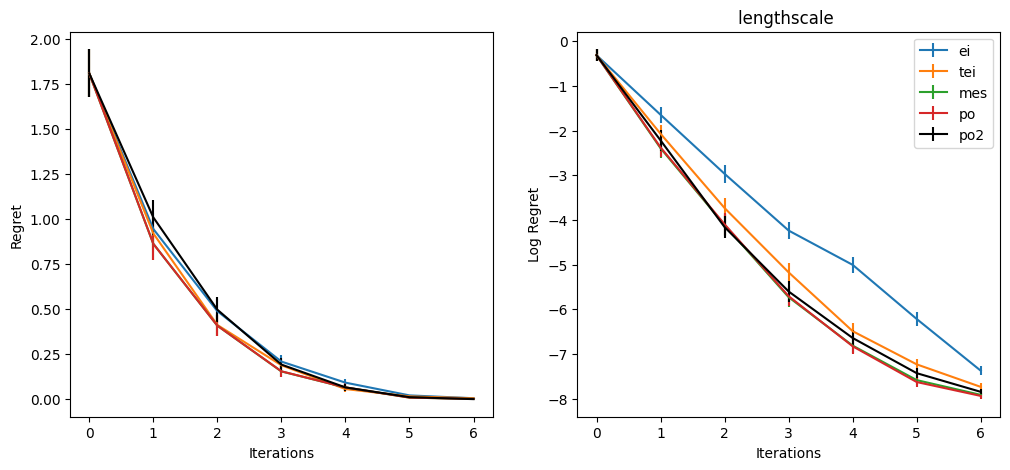

In [58]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

regret_holder11 = np.array(regret_holder11)
regret_holder22 = np.array(regret_holder22)
regret_holder33 = np.array(regret_holder33)
regret_holder44 = np.array(regret_holder44)
regret_holder55 = np.array(regret_holder55)

regret_holder_tei = np.concatenate((regret_holder1,regret_holder11),axis=0)
regret_holder_ei = np.concatenate((regret_holder2,regret_holder22),axis=0)
regret_holder_mes = np.concatenate((regret_holder3,regret_holder33),axis=0)
regret_holder_po = np.concatenate((regret_holder4,regret_holder44),axis=0)
regret_holder_po2 = np.concatenate((regret_holder5,regret_holder55),axis=0)

logregret_holder_tei = np.log(regret_holder_tei)
logregret_holder_ei = np.log(regret_holder_ei)
logregret_holder_mes = np.log(regret_holder_mes)
logregret_holder_po = np.log(regret_holder_po)
logregret_holder_po2 = np.log(regret_holder_po2)

logregret_holder_tei[logregret_holder_tei == float('-inf')] = -8
logregret_holder_ei[logregret_holder_ei == float('-inf')] = -8
logregret_holder_mes[logregret_holder_mes == float('-inf')] = -8
logregret_holder_po[logregret_holder_po == float('-inf')] = -8
logregret_holder_po2[logregret_holder_po2 == float('-inf')] = -8


N = 200
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder_tei,axis=0),np.std(regret_holder_tei,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder_ei,axis=0),np.std(regret_holder_ei,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder_mes,axis=0),np.std(regret_holder_mes,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder_po,axis=0),np.std(regret_holder_po,axis=0)/np.sqrt(N),label='po')
ax.errorbar(myxaxis,np.mean(regret_holder_po2,axis=0),np.std(regret_holder_po2,axis=0)/np.sqrt(N),label='po2',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder_tei,axis=0),np.std(logregret_holder_tei,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder_ei,axis=0),np.std(logregret_holder_ei,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder_mes,axis=0),np.std(logregret_holder_mes,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder_po,axis=0),np.std(logregret_holder_po,axis=0)/np.sqrt(N),label='po')
ax2.errorbar(myxaxis,np.mean(logregret_holder_po2,axis=0),np.std(logregret_holder_po2,axis=0)/np.sqrt(N),label='po2',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')
#ax2.set_ylim([-8.1,-7])

plt.title('lengthscale ')
plt.legend()

In [48]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)


logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)
logregret_holder5 = np.log(regret_holder5)



logregret_holder1[logregret_holder1 == float('-inf')] = -10
logregret_holder2[logregret_holder2 == float('-inf')] = -10
logregret_holder3[logregret_holder3 == float('-inf')] = -10
logregret_holder4[logregret_holder4 == float('-inf')] = -10
logregret_holder5[logregret_holder5 == float('-inf')] = -10


 /tmp/ipykernel_157840/3106101717.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3106101717.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3106101717.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3106101717.py:11: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_157840/3106101717.py:12: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


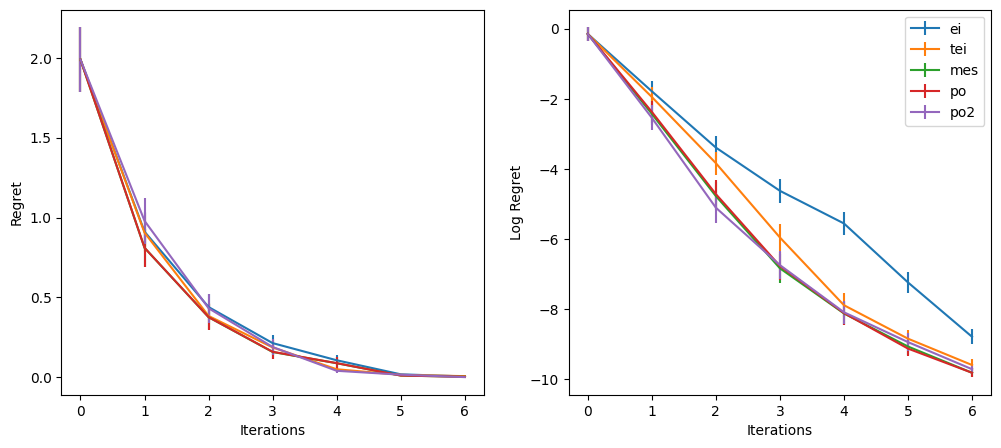

In [51]:
N = 100
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='po')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='po2')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='po')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='po2')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

In [29]:
with open('GP1d_PO', 'r') as f:
    regret_holder6 = np.loadtxt(f)
    
regret_holder6 = np.array(regret_holder6)
logregret_holder6 = np.log(regret_holder6)
logregret_holder6[logregret_holder6 == float('-inf')] = -8


# with open('GP1d_KG', 'r') as f:
#     regret_holder8 = np.loadtxt(f)
    
    
# regret_holder8 = np.array(regret_holder8)
# logregret_holder8 = np.log(regret_holder8)
# logregret_holder8[logregret_holder8 == float('-inf')] = -8


 /tmp/ipykernel_76363/2526095789.py:5: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


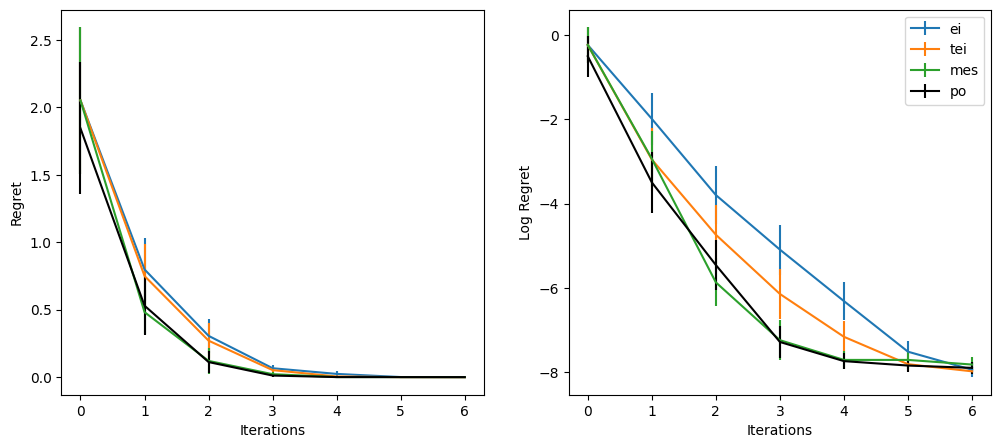

In [35]:
N = 20
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
# ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='mes')
# ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
ax.errorbar(myxaxis,np.mean(regret_holder6,axis=0),np.std(regret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
# ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='mes')
# ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
ax2.errorbar(myxaxis,np.mean(logregret_holder6,axis=0),np.std(logregret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

In [9]:
N = 40
regret_holder8 = []

X = np.linspace(1,10,401)

for exp in range(N):
  print(exp)
  np.random.seed(exp) 
  
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret8 = KG_BO(X_total=X,Y_total=Y, fstar=fstar, seed=exp)
  regret_holder8.append(regret8)


0
optimum is  9.585991162384163
1
optimum is  7.480696209365134
2
optimum is  7.659337771728448
3
optimum is  5.573693443898242
4
optimum is  1.647222644183288
5
optimum is  3.027759521565481
6
optimum is  5.315064539356177
7
optimum is  7.317235464279301
8
optimum is  6.0332943271691875
9
optimum is  13.27589813949267
10
optimum is  3.3388401018650296
11
optimum is  3.0592850578098503
12
optimum is  4.474318099865495
13
optimum is  2.7631635612051073
14
optimum is  2.016954550169007
15
optimum is  6.815897739435674
16
optimum is  -0.45050470426749784
17
optimum is  6.308902800450083
18
optimum is  -0.5646581153273824
19
optimum is  4.839130727088874
20
optimum is  7.038109470372545
21
optimum is  1.270062961441738
22
optimum is  7.9481157436360155
23
optimum is  5.534388851174199
24
optimum is  6.694145965984214
25
optimum is  5.742395748211348
26
optimum is  -1.187679112738551
27
optimum is  2.811428519449292
28
optimum is  6.29214224328179
29
optimum is  4.412696730468513
30
optimum

In [11]:
regret_holder8

[array([9.80213342, 1.98762138, 0.94553372, 0.06678771, 0.        ,
        0.        , 0.        ]),
 array([0.00173219, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.17564857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.21880927e+00, 5.59448394e-02, 2.66688217e-03, 9.36766486e-05,
        9.36766486e-05, 0.00000000e+00, 0.00000000e+00]),
 array([0.44597627, 0.00485913, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.26273911, 0.26273911, 0.00165833, 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.83320645, 0.83320645, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([4.10683049e+00, 2.25980596e+00, 3.39429420e-02, 2.74779755e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.58748067, 0.00805887, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([5.5134885 , 3.5577

In [12]:
regret_holder8 = np.array(regret_holder8)
logregret_holder8 = np.log(regret_holder8)
logregret_holder8[logregret_holder8 == float('-inf')] = -8

 /tmp/ipykernel_76363/1428689705.py:2: RuntimeWarning:divide by zero encountered in log


In [17]:
np.savetxt('GP1d_KG(EI_2truncated)', regret_holder8, delimiter=' ')

In [36]:
N = 40
regret_holder9 = []

X = np.linspace(1,10,401)

for exp in range(N):
  print(exp)
  np.random.seed(exp) 
  
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret9 = PO_BO_MC(X_total=X,Y_total=Y, fstar=fstar, seed=exp)
  regret_holder9.append(regret9)

0
optimum is  9.585991162384163
1
optimum is  7.480696209365134
2
optimum is  7.659337771728448
3
optimum is  5.573693443898242
4
optimum is  1.647222644183288
5
optimum is  3.027759521565481
6
optimum is  5.315064539356177
7
optimum is  7.317235464279301
8
optimum is  6.0332943271691875
9
optimum is  13.27589813949267
10
optimum is  3.3388401018650296
11
optimum is  3.0592850578098503
12
optimum is  4.474318099865495
13
optimum is  2.7631635612051073
14
optimum is  2.016954550169007
15
optimum is  6.815897739435674
16
optimum is  -0.45050470426749784
17
optimum is  6.308902800450083
18
optimum is  -0.5646581153273824
19
optimum is  4.839130727088874
20
optimum is  7.038109470372545
21
optimum is  1.270062961441738
22
optimum is  7.9481157436360155
23
optimum is  5.534388851174199
24
optimum is  6.694145965984214
25
optimum is  5.742395748211348
26
optimum is  -1.187679112738551
27
optimum is  2.811428519449292
28
optimum is  6.29214224328179
29
optimum is  4.412696730468513
30
optimum

In [37]:
regret_holder9

[array([9.80213342, 1.98762138, 0.29670485, 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.00173219, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.17564857, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([1.21880927, 0.02682071, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.44597627, 0.00485913, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.26273911, 0.26273911, 0.26273911, 0.        , 0.        ,
        0.        , 0.        ]),
 array([0.83320645, 0.83320645, 0.83320645, 0.        , 0.        ,
        0.        , 0.        ]),
 array([4.10683049, 2.25980596, 0.35493548, 0.01982079, 0.        ,
        0.        , 0.        ]),
 array([0.58748067, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 array([5.51348850e+00, 6.15398713e-01, 2.31299064e-03, 0.00000000e+00,
        0.

In [38]:
regret_holder9 = np.array(regret_holder9)
logregret_holder9 = np.log(regret_holder9)
logregret_holder9[logregret_holder9 == float('-inf')] = -8

 /tmp/ipykernel_4819/3191015050.py:2: RuntimeWarning:divide by zero encountered in log


In [40]:
np.savetxt('GP1d_PO_MC', regret_holder9, delimiter=' ')

In [31]:
regret_holder1 = regret_holder1[:40,:]
#regret_holder2 = regret_holder2[:40,:]
regret_holder3 = regret_holder3[:40,:]
regret_holder4 = regret_holder4[:40,:]
#regret_holder5 = regret_holder5[:40,:]
regret_holder6 = regret_holder6[:40,:]


logregret_holder1 = logregret_holder1[:40,:]
#logregret_holder2 = logregret_holder2[:40,:]
logregret_holder3 = logregret_holder3[:40,:]
logregret_holder4 = logregret_holder4[:40,:]
#logregret_holder5 = logregret_holder5[:40,:]
logregret_holder6 = logregret_holder6[:40,:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


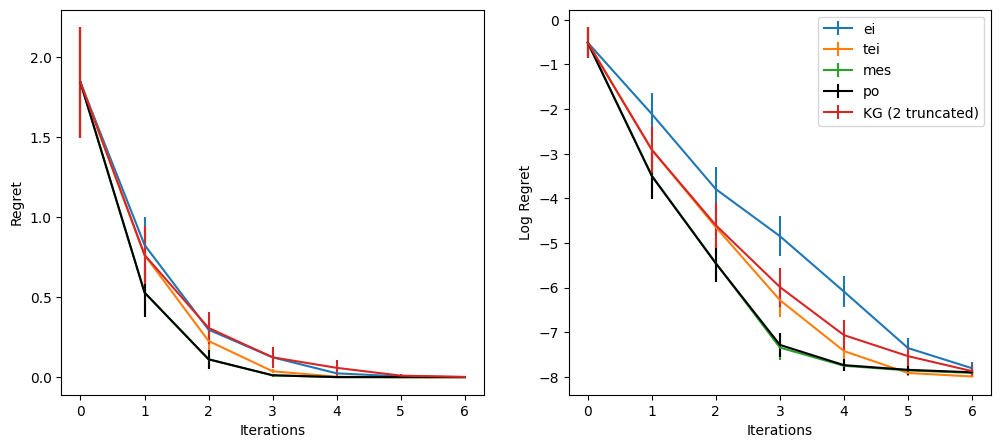

In [32]:
N = 40
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
#ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='mes')
#ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
ax.errorbar(myxaxis,np.mean(regret_holder6,axis=0),np.std(regret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
# ax.errorbar(myxaxis,np.mean(regret_holder7,axis=0),np.std(regret_holder7,axis=0)/np.sqrt(N),label='KG (two truncated)')
ax.errorbar(myxaxis,np.mean(regret_holder8,axis=0),np.std(regret_holder8,axis=0)/np.sqrt(N),label='KG')
#ax.errorbar(myxaxis,np.mean(regret_holder9,axis=0),np.std(regret_holder9,axis=0)/np.sqrt(N),label='PO(MC)')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
#ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='mes')
#ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
ax2.errorbar(myxaxis,np.mean(logregret_holder6,axis=0),np.std(logregret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
#ax2.errorbar(myxaxis,np.mean(logregret_holder7,axis=0),np.std(logregret_holder7,axis=0)/np.sqrt(N),label='KG (two truncated)')
ax2.errorbar(myxaxis,np.mean(logregret_holder8,axis=0),np.std(logregret_holder8,axis=0)/np.sqrt(N),label='KG (2 truncated)')
#ax2.errorbar(myxaxis,np.mean(logregret_holder9,axis=0),np.std(logregret_holder9,axis=0)/np.sqrt(N),label='PO(MC)')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


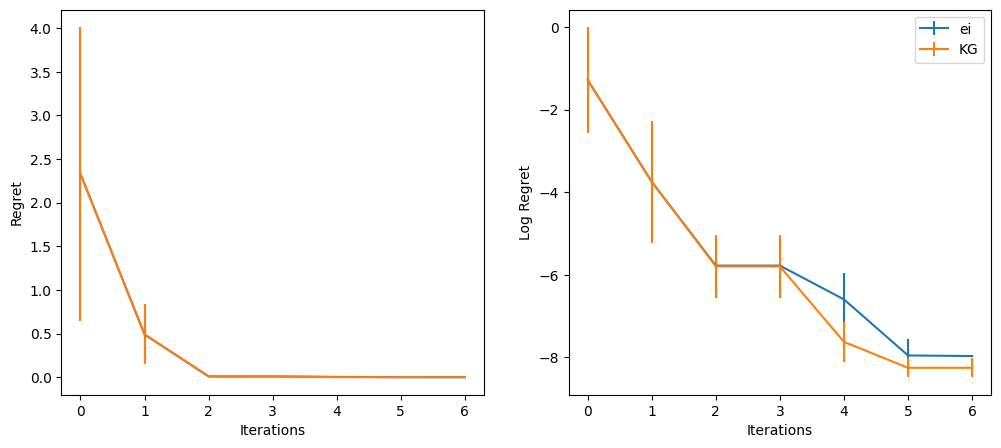

In [50]:
N = 5
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder8,axis=0),np.std(regret_holder8,axis=0)/np.sqrt(N),label='KG')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder8,axis=0),np.std(logregret_holder8,axis=0)/np.sqrt(N),label='KG')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

In [55]:
np.mean(regret_holder1,axis=0) == np.mean(regret_holder8,axis=0)

array([ True,  True, False, False, False, False, False])

In [53]:
np.mean(regret_holder8,axis=0)

array([2.32885994e+00, 4.90347928e-01, 1.07636441e-02, 1.07636441e-02,
       6.65274331e-04, 1.87353297e-05, 1.87353297e-05])

In [99]:
np.savetxt('GP1d_KG', regret_holder8, delimiter=' ')

overestimate the f_star

In [56]:
N = 100
regret_holder1 = []
regret_holder2 = []
regret_holder3 = []
regret_holder4 = []
regret_holder5 = []

X = np.linspace(1,10,401)

for exp in range(N):
  np.random.seed(exp) 
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret1 = normal_BO(X,Y,'ei',fstar=0.5+fstar,seed=exp)
  regret_holder1.append(regret1)

  regret2 = normal_BO(X,Y,'findmax',fstar=0.5+fstar,seed=exp)
  regret_holder2.append(regret2)

  regret3 = normal_BO(X,Y,'tei',fstar=0.5+fstar,seed=exp)
  regret_holder3.append(regret3)
  
  regret4 = normal_BO(X,Y,'mes',fstar=0.5+fstar,seed=exp)
  regret_holder4.append(regret4)
  
  regret5 = normal_BO(X,Y,'over_max',fstar=0.5+fstar,seed=exp)
  regret_holder5.append(regret5)

optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  9.585991162384163
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.480696209365134
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  7.659337771728448
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  5.573693443898242
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  1.647222644183288
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  3.027759521565481
optimum is  5.315064539356177
optimum is  5.315064539356177
optimum is  5.315064539356177
optimum is

In [57]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)
regret_holder5 = np.array(regret_holder5)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)
logregret_holder5 = np.log(regret_holder5)


logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8
logregret_holder4[logregret_holder4 == float('-inf')] = -8
logregret_holder5[logregret_holder5 == float('-inf')] = -8

 /tmp/ipykernel_18662/822952063.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_18662/822952063.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_18662/822952063.py:9: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_18662/822952063.py:10: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_18662/822952063.py:11: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


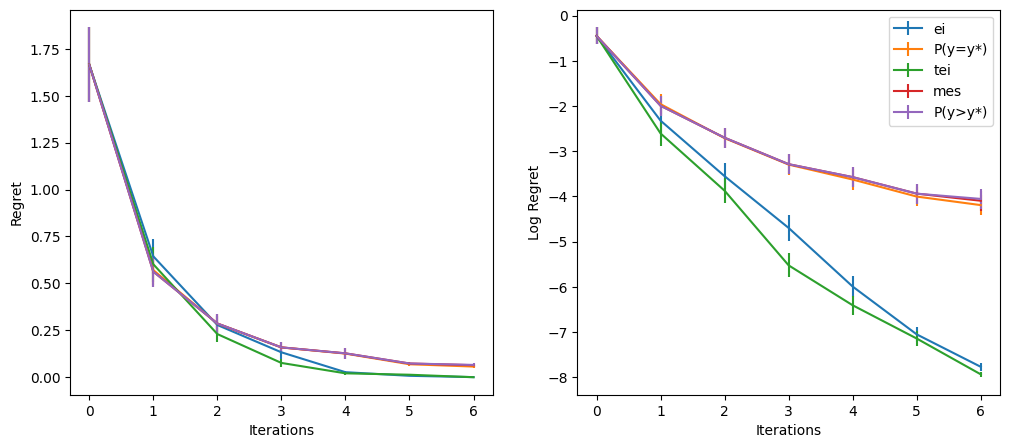

In [58]:
N = 100
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder5,axis=0),np.std(regret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
#ax.errorbar(myxaxis,np.mean(regret_holder6,axis=0),np.std(regret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='P(y=y*)')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder5,axis=0),np.std(logregret_holder5,axis=0)/np.sqrt(N),label='P(y>y*)')
#ax2.errorbar(myxaxis,np.mean(logregret_holder6,axis=0),np.std(logregret_holder6,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')

plt.legend()

# check MES and P(y>y*)

In [78]:
N = 1

X = np.linspace(1,10,401)

for exp in range(N):
  np.random.seed(exp) 
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(401,1),size=1)
  Y = Y.reshape(401,)
  
  fstar = np.max(Y)

  regret4, AF_holder_mes = normal_BO(X,Y,'mes',fstar=fstar,seed=exp)
  regret5, AF_holder_over_max = normal_BO(X,Y,'over_max',fstar=fstar,seed=exp)


optimum is  9.585991162384163
optimum is  9.585991162384163


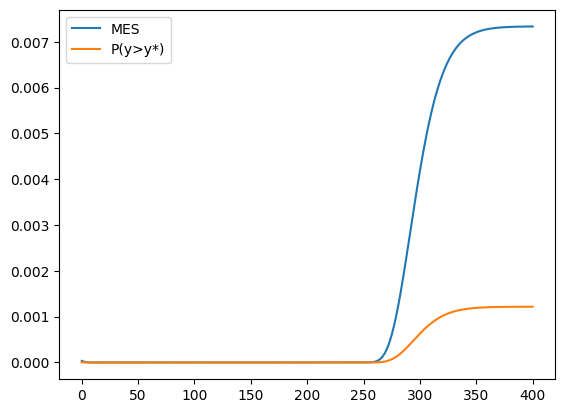

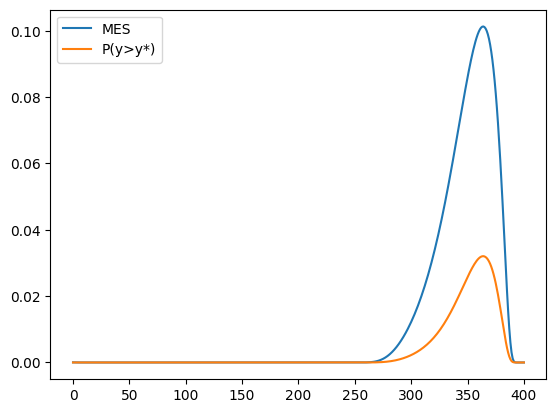

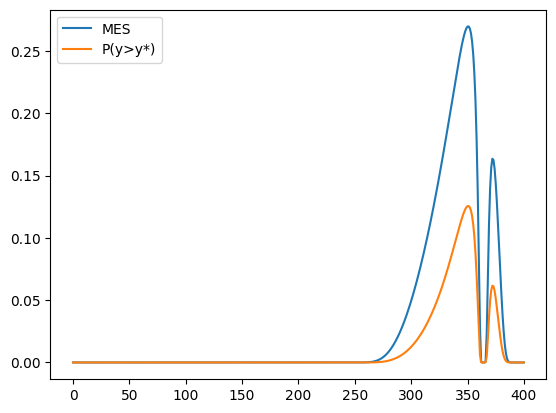

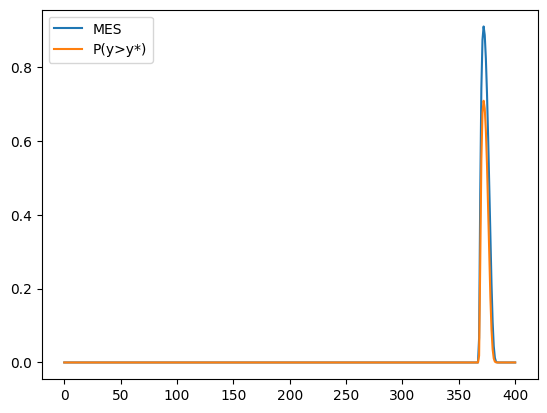

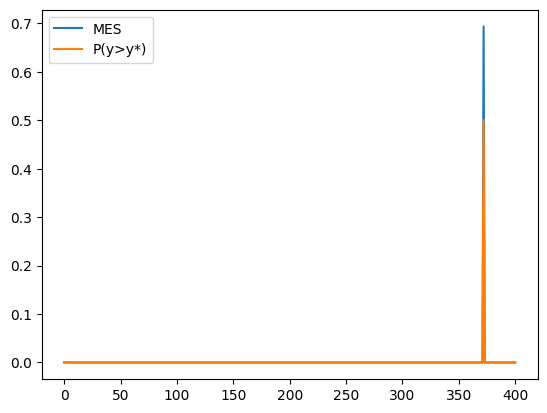

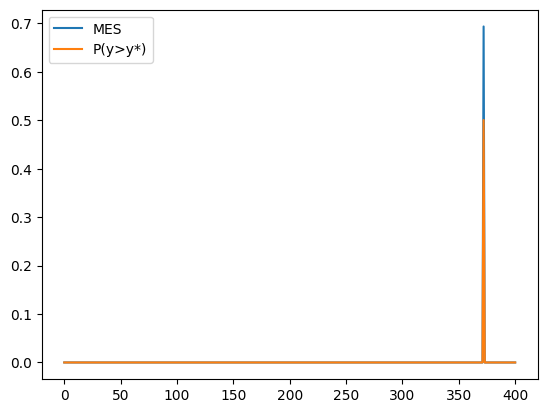

In [79]:
# f = plt.figure(figsize=(12,5))
# ax = plt.subplots(1,6)

for i in range(6):
    plt.figure()
    plt.plot(AF_holder_mes[i],label='MES')
    plt.plot(AF_holder_over_max[i],label='P(y>y*)')
    plt.legend()

In [7]:
N = 100
regret_holder1 = []
regret_holder2 = []
regret_holder3 = []
regret_holder4 = []


X = np.linspace(0,6,501)

for exp in range(N):
  print(exp)
  np.random.seed(exp) 
  
  temp = float(np.random.uniform(low=-2, high=2, size=1))
  X_sample=np.array([[0]])
  Y_sample=np.array([[temp]])

  kernel = GPy.kern.RBF(input_dim=1,variance=10,lengthscale=1.2)
  m = GPy.models.GPRegression(X_sample,Y_sample,kernel)
  m.Gaussian_noise.variance.fix(0.0)

  Y = m.posterior_samples_f(X.reshape(501,1),size=1)
  Y = Y.reshape(501,)
  
  fstar = np.max(Y)

  regret1 = normal_BO(X,Y,'ei',fstar=fstar,seed=exp)
  regret_holder1.append(regret1)

  regret2 = normal_BO(X,Y,'tei',fstar=fstar,seed=exp)
  regret_holder2.append(regret2)
  
  regret3 = normal_BO(X,Y,'mes',fstar=fstar,seed=exp)
  regret_holder3.append(regret3)
  
  regret4 = PO_BO(X,Y, fstar=fstar, seed=exp)
  regret_holder4.append(regret4)

0
optimum is  8.487768244587858
optimum is  8.487768244587858
optimum is  8.487768244587858
optimum is  8.487768244587858
1
optimum is  4.711073726097753
optimum is  4.711073726097753
optimum is  4.711073726097753
optimum is  4.711073726097753
2
optimum is  4.6313549723025575
optimum is  4.6313549723025575
optimum is  4.6313549723025575
optimum is  4.6313549723025575
3
optimum is  4.86273742653351
optimum is  4.86273742653351
optimum is  4.86273742653351
optimum is  4.86273742653351
4
optimum is  1.868100147015343
optimum is  1.868100147015343
optimum is  1.868100147015343
optimum is  1.868100147015343
5
optimum is  1.7079336499477578
optimum is  1.7079336499477578
optimum is  1.7079336499477578
optimum is  1.7079336499477578
6
optimum is  1.5715498697242964
optimum is  1.5715498697242964
optimum is  1.5715498697242964
optimum is  1.5715498697242964
7
optimum is  6.47752610370263
optimum is  6.47752610370263
optimum is  6.47752610370263
optimum is  6.47752610370263
8
optimum is  4.5776

In [8]:
regret_holder1 = np.array(regret_holder1)
regret_holder2 = np.array(regret_holder2)
regret_holder3 = np.array(regret_holder3)
regret_holder4 = np.array(regret_holder4)

logregret_holder1 = np.log(regret_holder1)
logregret_holder2 = np.log(regret_holder2)
logregret_holder3 = np.log(regret_holder3)
logregret_holder4 = np.log(regret_holder4)

logregret_holder1[logregret_holder1 == float('-inf')] = -8
logregret_holder2[logregret_holder2 == float('-inf')] = -8
logregret_holder3[logregret_holder3 == float('-inf')] = -8
logregret_holder4[logregret_holder4 == float('-inf')] = -8

 /tmp/ipykernel_4995/269342845.py:6: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_4995/269342845.py:7: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_4995/269342845.py:8: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_4995/269342845.py:9: RuntimeWarning:divide by zero encountered in log


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


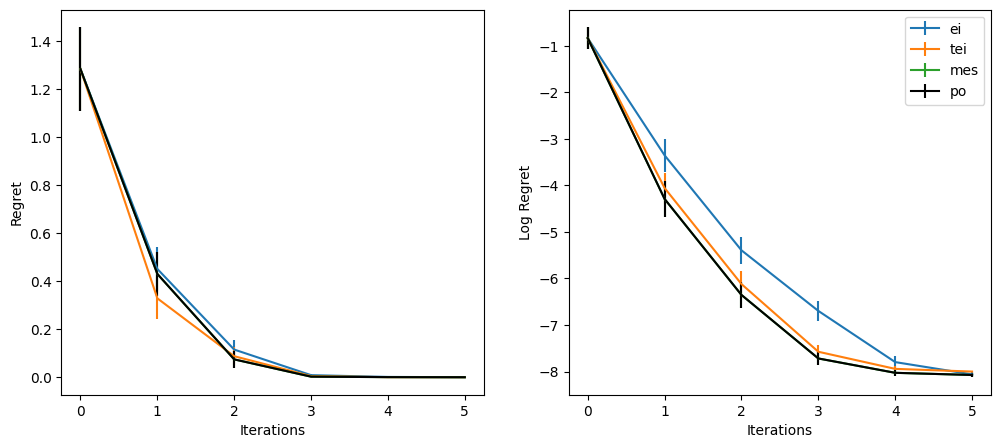

In [9]:
N = 80
myxaxis=range(regret_holder1.shape[1])

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.errorbar(myxaxis,np.mean(regret_holder1,axis=0),np.std(regret_holder1,axis=0)/np.sqrt(N),label='ei')
ax.errorbar(myxaxis,np.mean(regret_holder2,axis=0),np.std(regret_holder2,axis=0)/np.sqrt(N),label='tei')
ax.errorbar(myxaxis,np.mean(regret_holder3,axis=0),np.std(regret_holder3,axis=0)/np.sqrt(N),label='mes')
ax.errorbar(myxaxis,np.mean(regret_holder4,axis=0),np.std(regret_holder4,axis=0)/np.sqrt(N),label='po',color='black')
ax.set_xlabel('Iterations')
ax.set_ylabel('Regret')
plt.legend()


ax2.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
ax2.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
ax2.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
ax2.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='po',color='black')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Log Regret')
plt.legend()

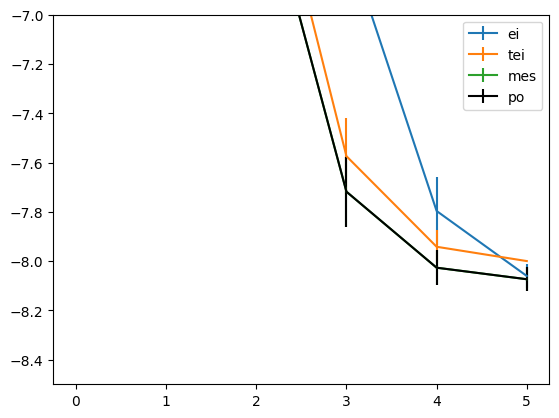

In [11]:
plt.errorbar(myxaxis,np.mean(logregret_holder1,axis=0),np.std(logregret_holder1,axis=0)/np.sqrt(N),label='ei')
plt.errorbar(myxaxis,np.mean(logregret_holder2,axis=0),np.std(logregret_holder2,axis=0)/np.sqrt(N),label='tei')
plt.errorbar(myxaxis,np.mean(logregret_holder3,axis=0),np.std(logregret_holder3,axis=0)/np.sqrt(N),label='mes')
plt.errorbar(myxaxis,np.mean(logregret_holder4,axis=0),np.std(logregret_holder4,axis=0)/np.sqrt(N),label='po',color='black')
plt.ylim([-8.5,-7])
plt.legend()


In [36]:
np.mean(logregret_holder4,axis=0)

array([-0.97554835, -4.7635891 , -6.62775088, -7.71273582, -8.03363991,
       -8.04821474, -8.06580848])

In [59]:
np.std(logregret_holder4,axis=0)/np.sqrt(200)

array([0.14190021, 0.2186517 , 0.16869306, 0.09135275, 0.04262918,
       0.03882472, 0.03203831])

In [37]:
np.mean(logregret_holder3,axis=0)

array([-0.97554835, -4.76971008, -6.61136015, -7.64522761, -7.9911021 ,
       -8.01465219, -8.02760497])

In [56]:
np.std(logregret_holder3,axis=0)/200

array([0.01003386, 0.01545307, 0.01179805, 0.00656059, 0.00243252,
       0.00219019, 0.00150566])

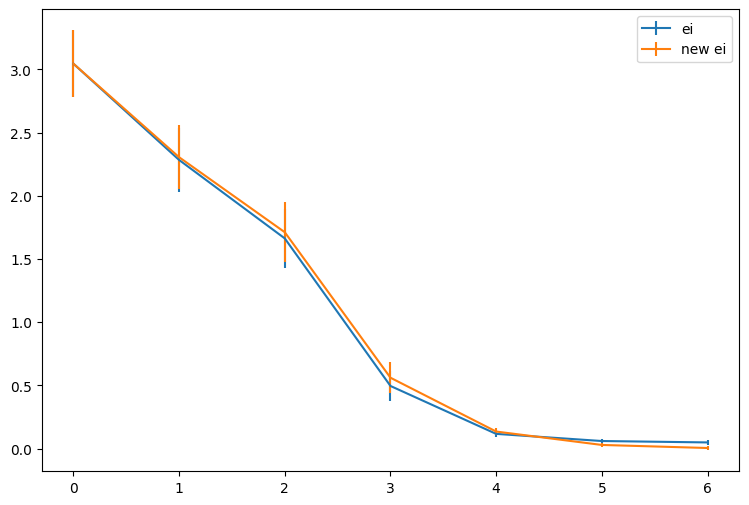

In [36]:
regret_holder_11 = np.array(regret_holder_11)
regret_holder_22 = np.array(regret_holder_22)
myxaxis=range(regret_holder_11.shape[1])



plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(regret_holder_11,axis=0),np.std(regret_holder_11,axis=0)/np.sqrt(100),label='ei')
plt.errorbar(myxaxis,np.mean(regret_holder_22,axis=0),np.std(regret_holder_11,axis=0)/np.sqrt(100),label='new ei')
plt.legend()

 /tmp/ipykernel_178489/2182638418.py:1: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_178489/2182638418.py:2: RuntimeWarning:divide by zero encountered in log


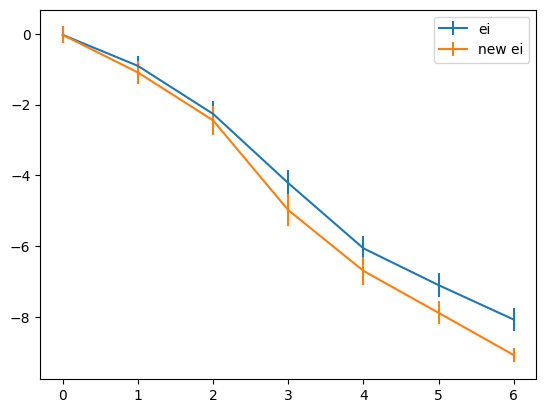

In [37]:
log_regret_holder_11 = np.log(regret_holder_11)
log_regret_holder_22 = np.log(regret_holder_22)

log_regret_holder_11[log_regret_holder_11 == float('-inf')] = -10
log_regret_holder_22[log_regret_holder_22 == float('-inf')] = -10

plt.errorbar(myxaxis,np.mean(log_regret_holder_11,axis=0),np.std(log_regret_holder_11,axis=0)/np.sqrt(100),label='ei')
plt.errorbar(myxaxis,np.mean(log_regret_holder_22,axis=0),np.std(log_regret_holder_22,axis=0)/np.sqrt(100),label='new ei')
plt.legend()


In [38]:
N = 100
regret_holder_33 = []

for exp in range(N):

  regret33 = my_new_BO(X,Y,exp)
  regret_holder_33.append(regret33)

optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.14667252654063
optimum is  7.

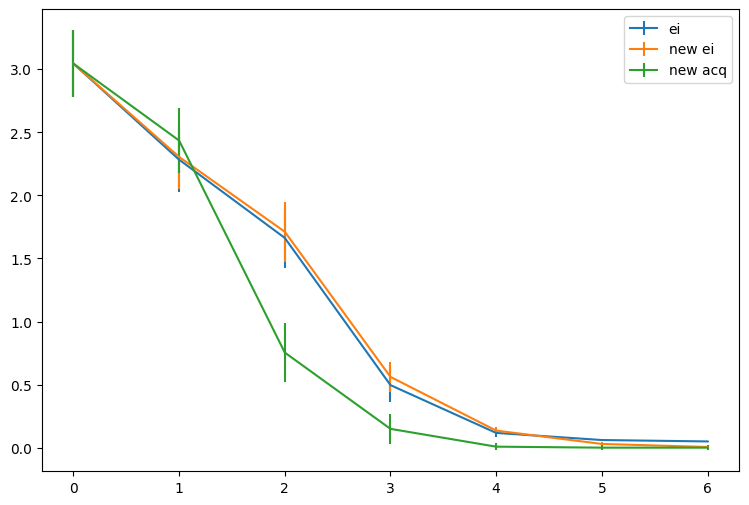

In [39]:
regret_holder_33 = np.array(regret_holder_33)

plt.figure(figsize=(9,6))
plt.errorbar(myxaxis,np.mean(regret_holder_11,axis=0),np.std(regret_holder_22,axis=0)/np.sqrt(100),label='ei')
plt.errorbar(myxaxis,np.mean(regret_holder_22,axis=0),np.std(regret_holder_11,axis=0)/np.sqrt(100),label='new ei')
plt.errorbar(myxaxis,np.mean(regret_holder_33,axis=0),np.std(regret_holder_11,axis=0)/np.sqrt(100),label='new acq')
plt.legend()

 /tmp/ipykernel_178489/860087927.py:1: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_178489/860087927.py:2: RuntimeWarning:divide by zero encountered in log
 /tmp/ipykernel_178489/860087927.py:3: RuntimeWarning:divide by zero encountered in log


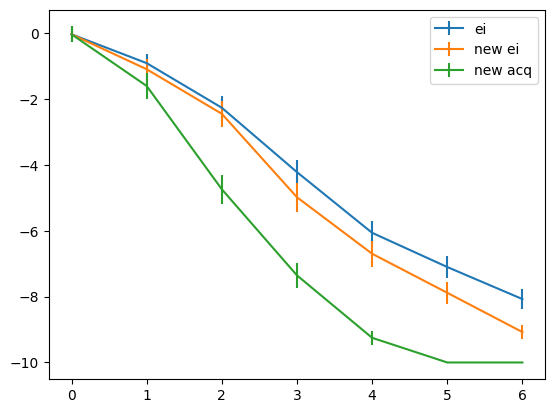

In [40]:
log_regret_holder_11 = np.log(regret_holder_11)
log_regret_holder_22 = np.log(regret_holder_22)
log_regret_holder_33 = np.log(regret_holder_33)

log_regret_holder_11[log_regret_holder_11 == float('-inf')] = -10
log_regret_holder_22[log_regret_holder_22 == float('-inf')] = -10
log_regret_holder_33[log_regret_holder_33 == float('-inf')] = -10

plt.errorbar(myxaxis,np.mean(log_regret_holder_11,axis=0),np.std(log_regret_holder_11,axis=0)/np.sqrt(100),label='ei')
plt.errorbar(myxaxis,np.mean(log_regret_holder_22,axis=0),np.std(log_regret_holder_22,axis=0)/np.sqrt(100),label='new ei')
plt.errorbar(myxaxis,np.mean(log_regret_holder_33,axis=0),np.std(log_regret_holder_33,axis=0)/np.sqrt(100),label='new acq')
plt.legend()

In [41]:
np.savetxt('function1d_2_ei', regret_holder_11, delimiter=',')
np.savetxt('function1d_2_new_ei', regret_holder_22, delimiter=',')
np.savetxt('function1d_2_new_acq', regret_holder_33, delimiter=',')

In [16]:
N = 100
regret_holder_44 = []


for exp in range(N):

  regret44 = paper_BO(X,Y,'ei',exp)
  regret_holder_44.append(regret44)

optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
True
True
True
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
True
True
True
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
True
True
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
False
optimum is  7.14667252654063
True
True
True
True
True
True
optimum is  7.14667252654063
True
True
True
False
optimum is  7.14667252654063
True
True
True
True
True
True
optimum is  7.14667252654063
False
optimum is  7.14667252654063
True
True
True
True
True
True
optimum is  7.14667252654063
True
False
optimum is  7.14667252654

In [17]:
regret_holder_44 = np.array(regret_holder_44)

In [ ]:
np.savetxt('function1d_2_erm', regret_holder_44, delimiter=',')